<a href="https://colab.research.google.com/github/barnabasp/ML_Course/blob/main/bporfy_lab_10_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10. Convolutional neural networks

In this assignment you'll use a photo-Z dataset acquired from the observations of the SDSS telescope located in New Mexico. The goal is to predict redshifts from multiband images of galaxies. As a warmup you'll work with the SVHN dataset.

**<font color='red'>[WARN]:</font> For this assignment you'll need significantly more computational power compared to previous assignments! If you don't have a CUDA-capable GPU with >4Gb VRAM and >8Gb RAM, then you're advised to work on Google Colab!**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!unzip /content/drive/MyDrive/Colab\ Notebooks/10/archive.zip

Initial setup above

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

In [5]:
!pip install extra-keras-datasets

In [6]:
from extra_keras_datasets import svhn
import tensorflow as tf
import keras
from sklearn import metrics

### 1. Load the Street View House Numbers (SVHN) dataset

-   Download the SVHN database and load the train and test datasets!
    There are multiple ways to do this. The easiest one is probably to install
    and use the `extra-keras-datasets` Python package. You need to use the
    standard/normal SVHN dataset only and NOT the one titled as `extra`!
    (Of course, if you have enough RAM and VRAM, you can work with that one
    too, if you want...)
-   Preprocess the downloaded data if needed to be able to use it for training
    and testing!
-   Normalize the pixel values into the interval of [0,1]!
-   How many and what classes do we have in the dataset? How many train and test
    examples do we have?
-   What are the dimensions of the images?
-   Show some images randomly from the dataset!
-   Make one-hot encoding for the labels!

Download and check the data

In [7]:
(X_train, y_train), (X_test, y_test) = svhn.load_data(type='normal')

INFO:root:Loading dataset = svhn


In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

In [9]:
np.isnan(X_train).sum(),np.isnan(y_train).sum(),np.isnan(X_test).sum(),np.isnan(y_test).sum()

(0, 0, 0, 0)

Need to make the pixels between 0 and 1.

In [10]:
X_train.min(), X_train.max()

(0, 255)

In [11]:
# from https://www.tutorialspoint.com/keras/keras_convolution_neural_network.htm
# not really needed, but this is less hard coded, of course
from keras import backend as K
img_rows, img_cols = 32, 32

if K.image_data_format() == 'channels_first': 
   x_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols) 
   x_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols) 
   input_shape = (1, img_rows, img_cols) 
else: 
   x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3) 
   x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3) 
   input_shape = (img_rows, img_cols, 3) 
   
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
x_train /= 255 
x_test /= 255

Both above and below options are working.

In [12]:
x_train = X_train.reshape(73257, 32, 32, 3)/255
x_test = X_test.reshape(26032, 32, 32, 3)/255

Shapes of the sets in order: input train, output train, input test, output test

In [13]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((73257, 32, 32, 3), (73257,), (26032, 32, 32, 3), (26032,))

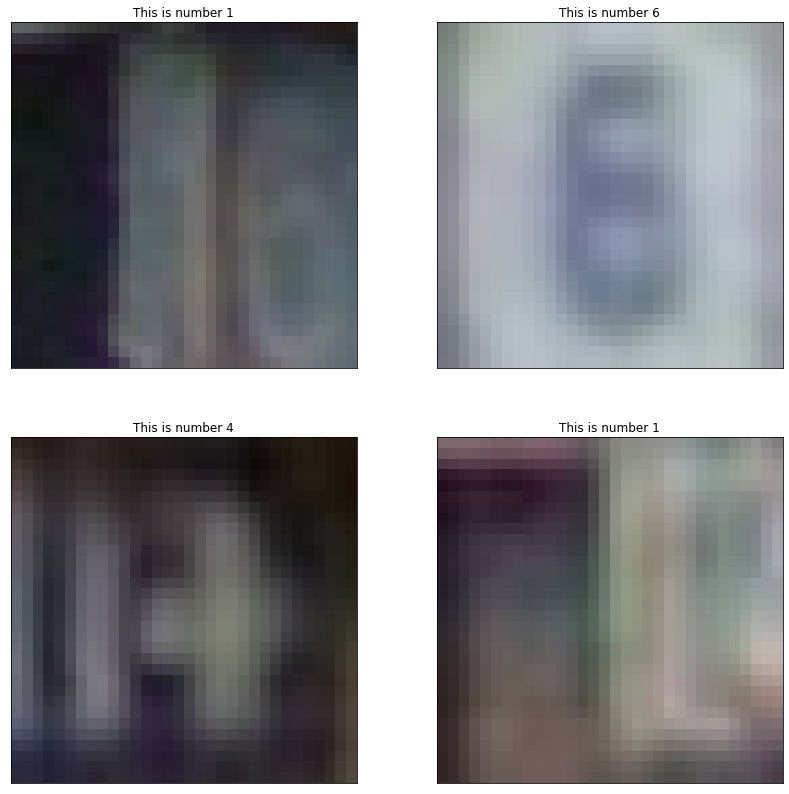

In [14]:
idx = [x for x in range(len(x_train))] #load up the indices , maybe not the best
random.shuffle(idx)
nrows, ncols =2, 2
fig, ax = plt.subplots(nrows,ncols,figsize=(14,14))
for i in range(ncols):
    for j in range(nrows):
        idxs = idx[i+j*ncols]
        image = x_train[idxs].reshape(32,32,3)
        ax[i,j].imshow(image)
        ax[i,j].set_title('This is number %i'%y_train[idxs])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [15]:
print("Unique classes: ", len(np.unique(y_test)))

Unique classes:  10


In [16]:
np.unique(y_test-1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

One hot encoding, seems OK!

In [17]:
y_train_oh = tf.keras.utils.to_categorical(y_train-1, 10)
y_test_oh = tf.keras.utils.to_categorical(y_test-1, 10)
print(y_train_oh[:5], y_train[:5])

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]] [1 9 2 3 2]


### 2. Create a convolutional neural network for the SVHN dataset

-   Train the following network on the training set and generate
    prediction for the test images:
    ```
          > conv2D, 16 kernels, kernel size = (3,3), valid padding, relu actvation
          > conv2D, 16 kernels, kernel size = (3,3), valid padding, relu actvation
          > maxpooling kernel size = (2,2)
          > conv2D, 32 kernels, kernel size = (3,3), valid padding, relu actvation
          > conv2D, 32 kernels, kernel size = (3,3), valid padding, relu actvation
          > maxpooling pool size = (2,2) strides = (2,2)
          > flatten
          > dense, 10 neurons, softmax activation
    ```
    -   Use Adam optimizer with default parameters
    -   Use categorical crossentropy as loss function
    -   Compile the model
    -   Print out a summary of the model
    -   Train the CNN on the training data for 25 epochs with batch size
        of 64
    -   Use the test data as validation data

-   Calculate the categorical cross-entropy loss and the accuracy!
    **<font color='green'>[HINT]:</font>** you should get at least $\approx$ 80-90%
    accuracy.
-   Plot the training and the validation loss and accuracy on the same plot!
    Do we experience overfitting?
-   Show the confusion matrix of the predictions!

Aided with understanding the exercise: https://www.tutorialspoint.com/keras/keras_convolution_neural_network.htm

In [18]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, BatchNormalization 
from keras.layers import Conv2D, MaxPooling2D 

In [19]:
x_train.shape

(73257, 32, 32, 3)

In [20]:
model = tf.keras.Sequential()
model.add(Conv2D(16,
                 kernel_size=(3,3),
                 padding='valid',
                 activation='relu'))
model.add(Conv2D(16, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))


In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','AUC'])

In [22]:
history = model.fit(x=x_train, y=y_train_oh,
                    batch_size=64, epochs=25,
                    validation_data=(x_test, y_test_oh))

Epoch 1/25
1145/1145 [==============================] - 25s 14ms/step - loss: 0.9098 - accuracy: 0.7157 - auc: 0.9504 - val_loss: 0.6085 - val_accuracy: 0.8362 - val_auc: 0.9744
Epoch 2/25
1145/1145 [==============================] - 15s 13ms/step - loss: 0.4980 - accuracy: 0.8583 - auc: 0.9827 - val_loss: 0.5400 - val_accuracy: 0.8528 - val_auc: 0.9789
Epoch 3/25
1145/1145 [==============================] - 15s 13ms/step - loss: 0.4290 - accuracy: 0.8758 - auc: 0.9865 - val_loss: 0.4824 - val_accuracy: 0.8611 - val_auc: 0.9830
Epoch 4/25
1145/1145 [==============================] - 15s 13ms/step - loss: 0.3888 - accuracy: 0.8874 - auc: 0.9887 - val_loss: 0.4548 - val_accuracy: 0.8712 - val_auc: 0.9842
Epoch 5/25
1145/1145 [==============================] - 15s 13ms/step - loss: 0.3617 - accuracy: 0.8947 - auc: 0.9897 - val_loss: 0.4316 - val_accuracy: 0.8782 - val_auc: 0.9859
Epoch 6/25
1145/1145 [==============================] - 15s 13ms/step - loss: 0.3400 - accuracy: 0.9005 - auc:

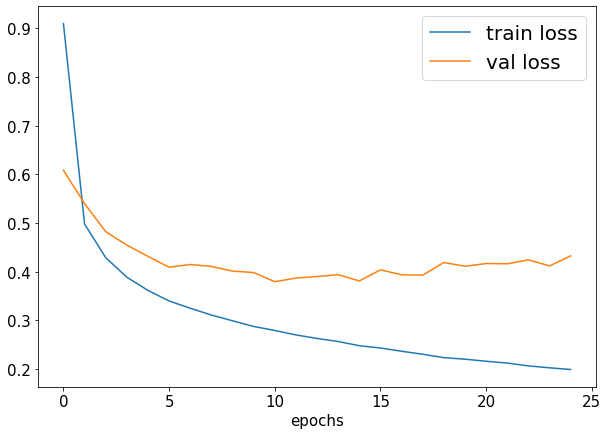

In [23]:
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [24]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = y_pred + 1

In [25]:
np.unique(y_pred)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

Text(0.5, 103.73999999999997, 'Predicted')

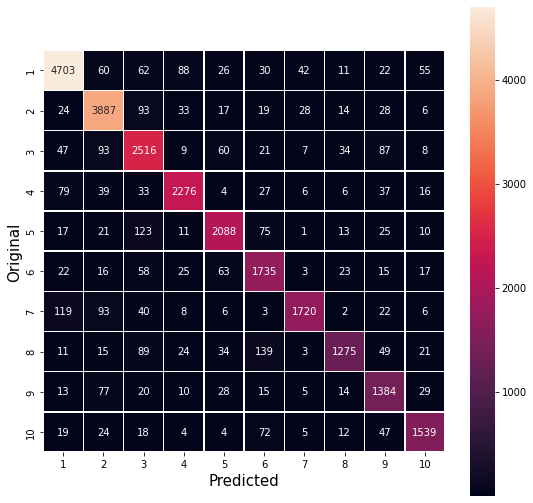

In [26]:
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            linewidths=.5,
            square = True,
            xticklabels=np.unique(y_pred),
            yticklabels=np.unique(y_pred))
plt.ylabel('Original',fontsize=15)
plt.xlabel('Predicted',fontsize=15)


### 3. Load the Sload Digital Sky Survey (SDSS) Dataset

You can download the dataset from Kaggle via
[this link](https://www.kaggle.com/masterdesky/multiband-photoz-sdss-dr16).

-   Download the images from Kaggle (~10'000 images total) 
-   Preprocess the images similarly to the SVHN dataset if needed! (Normalize
    pixel values to [0,1], etc.)
-   What are the dimensions of the images?
-   Show 15 images randomly from the dataset!
-   Create a train-test-validation split using `train_test_split` from `sklearn`
    where the test size is $0.33$ and the validation size is $0.2$
    -   Set a random seed
    -   Print the number of images in each of these sets after you've created
        them

In [27]:
df = pd.read_csv('skyserver_photoZ_data_DR16.csv')
df.head(3)

,specObjID,ra,dec,z
0,5457255364792963072,179.94568,5.601128,0.611592
1,5457264435763892224,179.87307,5.536654,0.519419
2,947020949721475072,179.87175,5.579883,0.129071


from https://stackoverflow.com/questions/39195113/how-to-load-multiple-images-in-a-numpy-array

In [28]:
import cv2
import os

instances = []

# Load in the images
for filepath in os.listdir('images/'):
    instances.append(cv2.imread('images/{0}'.format(filepath),1))

print(type(instances[0]))
instances = np.array(instances)

<class 'numpy.ndarray'>


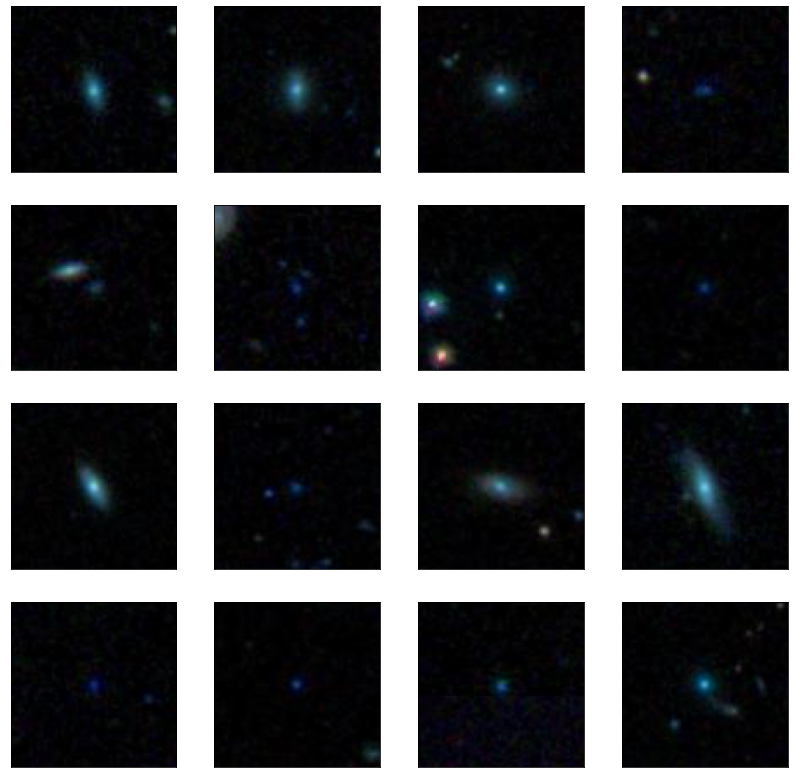

In [29]:
idx = [x for x in range(len(instances))] #load up the indices , maybe not the best
random.shuffle(idx)
nrows, ncols =4, 4
fig, ax = plt.subplots(nrows,ncols,figsize=(14,14))
for i in range(ncols):
    for j in range(nrows):
        idxs = idx[i+j*ncols]
        image = instances[idxs].reshape(96,96,3)
        ax[i,j].imshow(image)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [30]:
instances.shape, instances.max(), instances.min()

((9847, 96, 96, 3), 255, 0)

In [31]:
imgs = instances.reshape(instances.shape)/255

In [32]:
imgs.max(), imgs.min()

(1.0, 0.0)

In [33]:
from sklearn.model_selection import train_test_split #to split up the data into training and testing

from https://www.malicksarr.com/split-train-test-validation-python/

In [34]:
X_train, X_test, y_train, y_test = train_test_split(imgs,
                 df['z'].values,
                 test_size=0.33,
                 random_state=727,
                 shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                 y_train,
                 test_size=0.33/0.67,
                 random_state=727)


In [35]:
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))

X_train shape: (3347, 96, 96, 3)
X_test shape: (3250, 96, 96, 3)
y_train shape: (3347,)
y_test shape: (3250,)
X_val shape: (3250, 96, 96, 3)
y val shape: (3250,)


In [36]:
type(X_train), type(y_train), type(X_test), type(y_test), type(X_val), type(y_val)

(numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray,
 numpy.ndarray)

### 4. Create a convolutional neural network for the SDSS dataset

-   Train the following network on the training set and generate
    prediction for the test images:
    ```
          > conv2D, 32 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > conv2D, 32 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > maxpooling pool size = (2,2), strides = (2,2)
          
          > conv2D, 64 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > conv2D, 64 kernels, kernel size = (1,1), same padding
          > batch normalization
          > relu actvation
          > conv2D, 64 kernels, kernel size = (3,3), same padding
          > batch normalization
          > relu actvation
          > maxpooling pool size = (2,2), strides = (2,2)
          
          > global pooling
          > dense, 1 neuron, no activation
    ```

    -   Use Adam optimizer with default parameters
    -   Use mean squared error as loss function
    -   Compile the model
    -   Print out a summary of the model
    -   Use the created validation set as validation during the training
    -   Train the CNN on the training data for 25 epochs with batch size
        of 64

-   Calculate and print out the final accuracy using the R2 score!

In [37]:
from tensorflow.keras import activations
#https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/

In [38]:
model = tf.keras.Sequential()
model.add(Conv2D(32,
                 kernel_size=(3,3),
                 padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(activations.relu))
model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(activations.relu))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(activations.relu))
model.add(Conv2D(64, kernel_size=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(activations.relu))
model.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Activation(activations.relu))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(tf.keras.layers.GlobalMaxPooling2D())
model.add(Dense(1, activation=None))

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
#removing metrics AUC solved the issue I was having. 
#Credits to https://stackoverflow.com/questions/68521467/invalidargumenterror-assertion-failed-predictions-must-be-0-condition-x

In [40]:
history = model.fit(x=X_train, y=y_train,
                    batch_size=64, epochs=25,
                    validation_data=(X_val, y_val))

Epoch 1/25
53/53 [==============================] - 12s 176ms/step - loss: 5.0718 - accuracy: 0.0000e+00 - val_loss: 0.0634 - val_accuracy: 0.0000e+00
Epoch 2/25
53/53 [==============================] - 8s 142ms/step - loss: 0.2017 - accuracy: 0.0000e+00 - val_loss: 0.1658 - val_accuracy: 0.0000e+00
Epoch 3/25
53/53 [==============================] - 8s 143ms/step - loss: 0.1592 - accuracy: 0.0000e+00 - val_loss: 0.1759 - val_accuracy: 0.0000e+00
Epoch 4/25
53/53 [==============================] - 8s 144ms/step - loss: 0.1223 - accuracy: 0.0000e+00 - val_loss: 0.1376 - val_accuracy: 0.0000e+00
Epoch 5/25
53/53 [==============================] - 8s 159ms/step - loss: 0.1243 - accuracy: 0.0000e+00 - val_loss: 0.0999 - val_accuracy: 0.0000e+00
Epoch 6/25
53/53 [==============================] - 8s 144ms/step - loss: 0.1118 - accuracy: 0.0000e+00 - val_loss: 0.0693 - val_accuracy: 0.0000e+00
Epoch 7/25
53/53 [==============================] - 8s 144ms/step - loss: 0.0873 - accuracy: 0.0000

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 96, 96, 32)       

In [42]:
y_pred = model.predict(X_test)[:,0]

In [43]:
metrics.r2_score(y_test, y_pred)

-0.48480065603617417

### 5. Evaluate performance

-   Plot the training and the validation loss on the same plot!
-   Show the predicted values vs the actual labels on a plot!
-   Where does the model make mistakes? Try to plot the images corresponding to
    some outlier values!

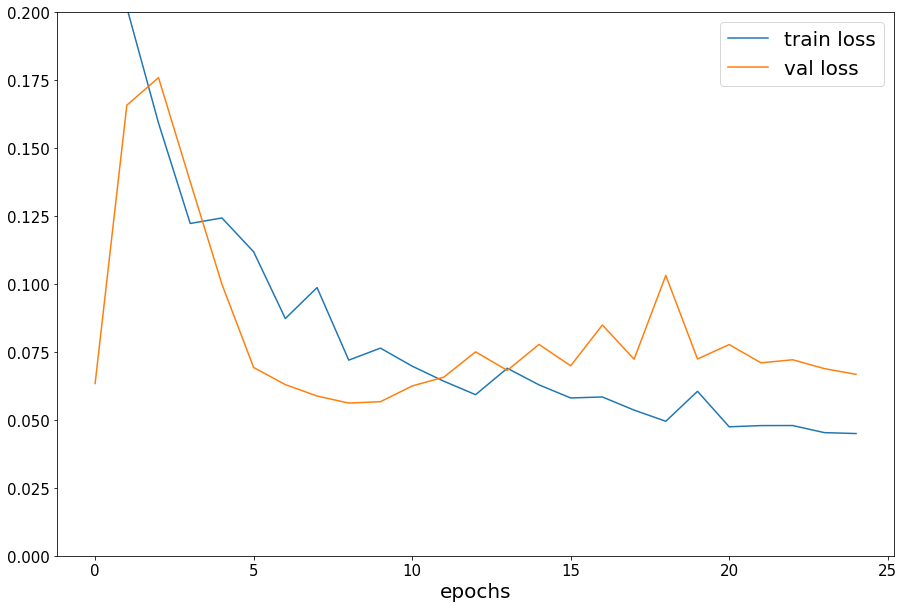

In [44]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,0.2)
plt.show()

In [45]:
y_test.shape, y_pred.shape

((3250,), (3250,))

Check out how the predicted versus test values look like

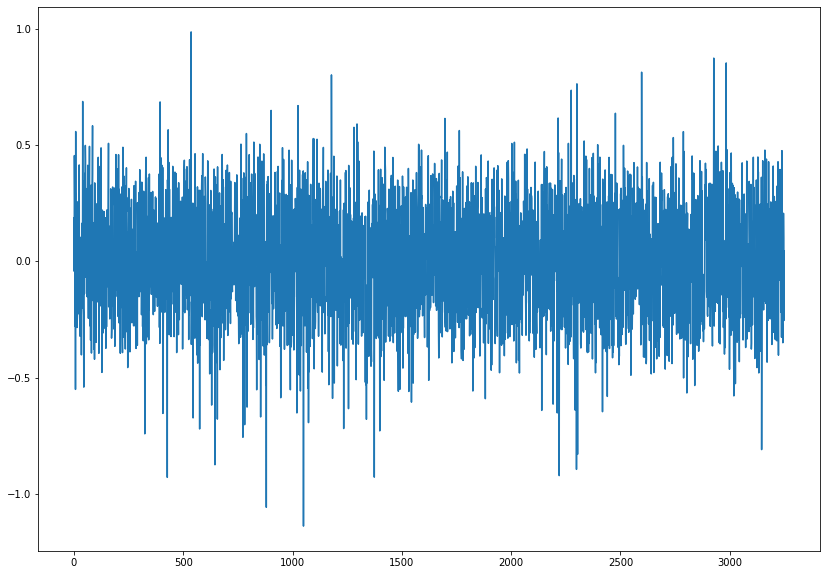

In [46]:
plt.figure(figsize=(14,10))
plt.plot(y_test - y_pred)

Not the best, check out the values' histogram on each other

(array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 8 Text major ticklabel objects>)

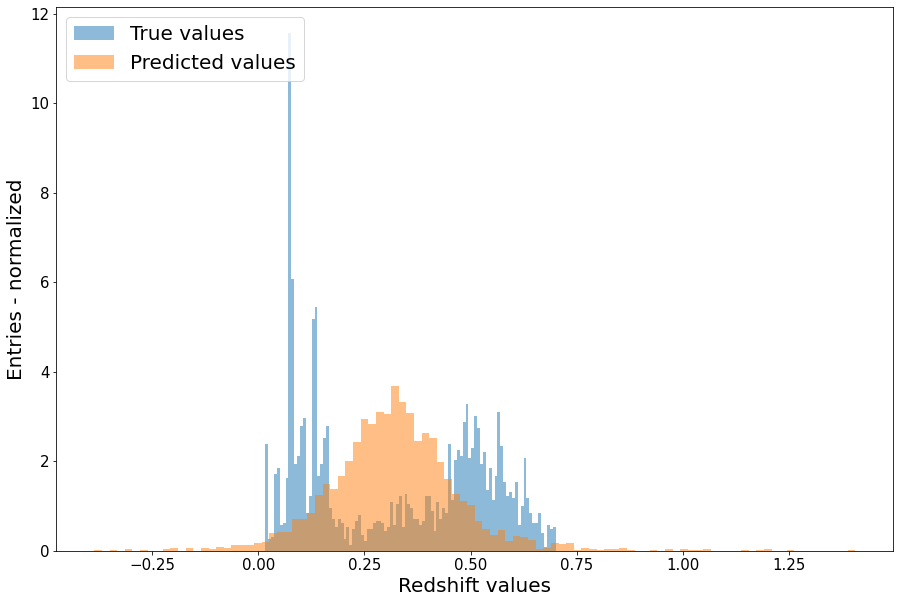

In [47]:
plt.figure(figsize=(15,10))
_ = plt.hist(y_test, density=True, alpha=0.5, label='True values', bins=100)
pred_cnt, pred_bin, _ = plt.hist(y_pred, density=True, alpha=0.5, label='Predicted values', bins=100)
plt.legend(fontsize=20,loc='upper left')
plt.xlabel('Redshift values', fontsize=20)
plt.ylabel('Entries - normalized', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

Interestingly, the predicted values seem to follow a Gaussian distribution

In [48]:
#filter for true and incorrect labels
true_labels = y_test 
incorrect = []
for i in range(len(y_pred)):
    if(y_pred[i].argmax() != true_labels[i]):
        incorrect.append(i)

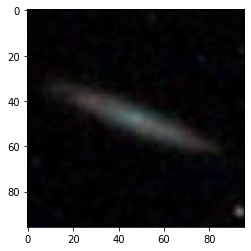

In [49]:
#check one image
plt.imshow(X_test[727].reshape(96,96,3))

In [50]:
def show_incorrects(n=10, m=10, fail = []):
    fig, ax = plt.subplots(nrows=m, ncols=n, figsize=(n+15,m+15))
    preds = model.predict(X_test)
    true_labels = y_test
    for j in range(m):
        for i in range(n):
            idx = fail[j*n+i]
            predstr = 'pred: ' + str(preds[idx].argmax()) + ', prob: ' + str(int(np.round(preds[idx].max()*100,0))) + '%'
            ax[j, i].imshow(X_test[idx].reshape(96, 96, 3))
            ax[j, i].set_title(predstr + ' / true: ' + str(true_labels[idx]),fontsize=10)
    fig.tight_layout()
    plt.show()  

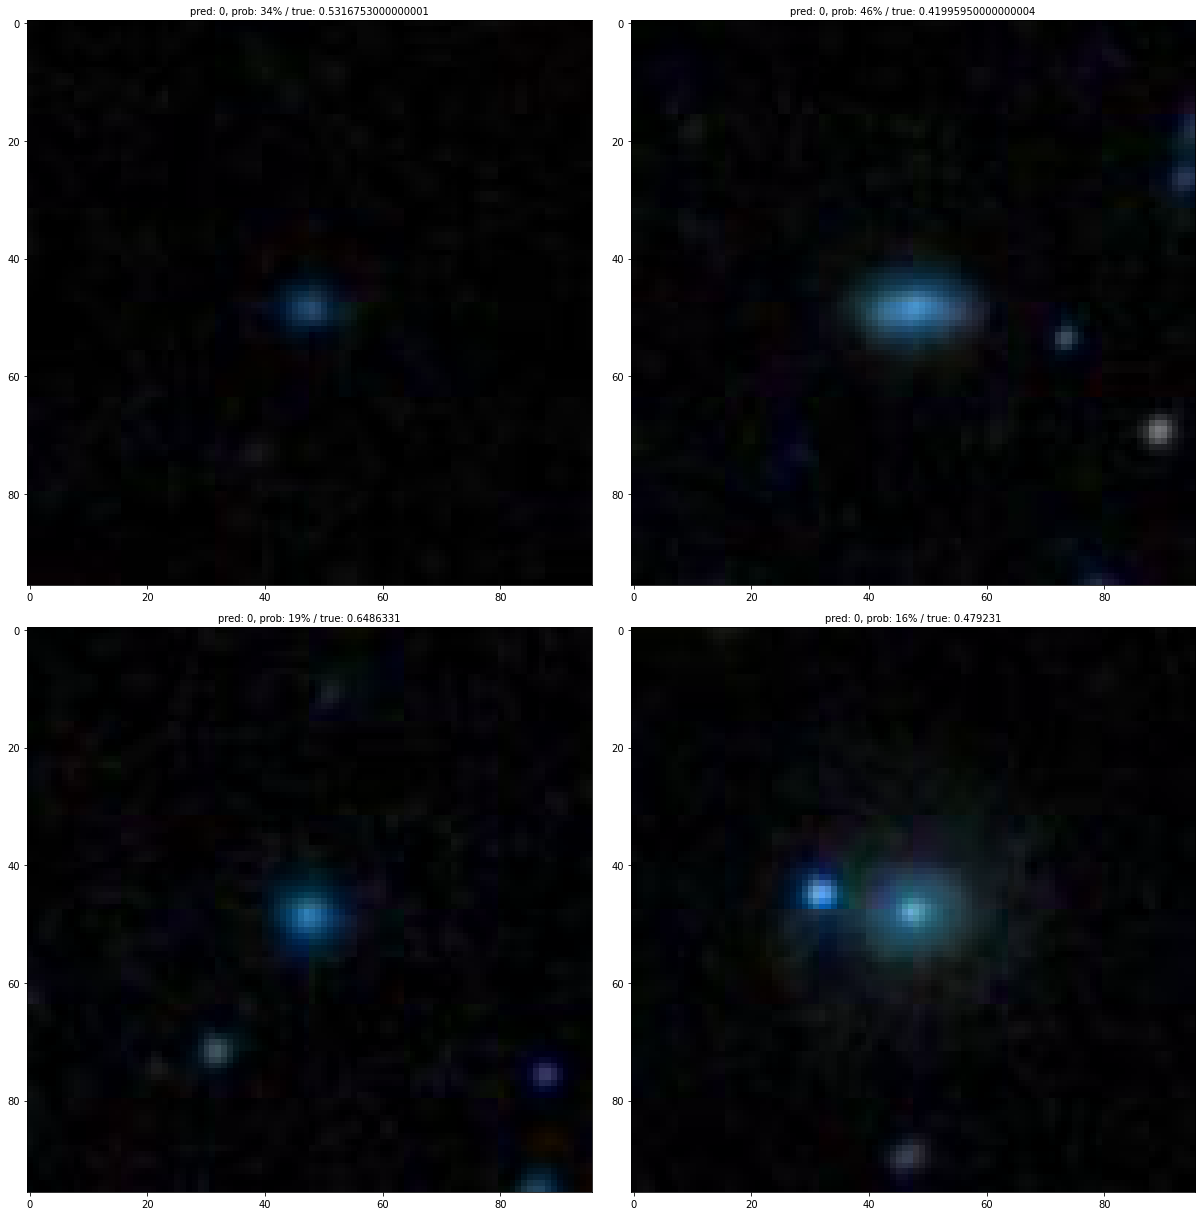

In [51]:
show_incorrects(n=2,m=2,fail=incorrect)

### 6. Train an other CNN

-   The previous architecture can be further improved.
-   Come up with an architecture that can achieve more than 80-85% accuracy on 
    the test set if the accuracy metric is the R2 score!
    -   You can use any tool for this task.
    -   Remember that there are different losses and optimizers, early stopping,
        regularization, etc. that can be useful for you. You can find more about 
        these eg. in the
        [tensorflow/keras documentation](https://www.tensorflow.org/api_docs/python/tf/all_symbols).
    -   Don't forget that you can add more layers to the model and train for
        more epochs too... :)
-   Print out the summary of this model!
-   Plot the loss curves for this model too!